# Fake News Detection – Szövegbányászati és NLP alapú elemzés


Ez a notebook bemutatja, hogyan lehet automatikusan elkülöníteni a valódi és álhír jellegű cikkeket szövegbányászati és NLP módszerekkel. A felhasznált adat a Kaggle [„Fake and Real News Dataset”](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset), amely két CSV-ben (Fake.csv és True.csv) tartalmazza a cikkeket. A feldolgozás során szöveg-előfeldolgozást, TF-IDF alapú osztályozást (logisztikus regresszió, LinearSVC), témamodellezést (LDA), valamint szóvektoros és egyszerű gráfos ábrázolásokat készítünk. A notebook minden cellája egymásra épül, így fentről lefelé futtatható.

## 1. Adatforrás és környezet
Az első részben beállítjuk a szükséges könyvtárakat, letöltjük a stopword-öket, betöltjük a spaCy angol modellt, és rögzítjük a véletlenszám-generátorokat a reprodukálhatóságért.

In [3]:
# Könyvtárak importálása
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import spacy

from gensim.corpora import Dictionary
from gensim.models import LdaModel, Word2Vec

import networkx as nx

from scipy.spatial.distance import cosine

from sklearn.manifold import TSNE

# Kiegészítő modulok
import re
import random
from collections import Counter
from itertools import combinations

# Stopword-ök letöltése
nltk.download("stopwords")

# SpaCy modell betöltése
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Reprodukálhatóság
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bobo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Ábrák és táblázatok olvashatóságának beállítása
plt.style.use("default")
sns.set()
pd.set_option("display.max_colwidth", 200)


### 1.3 Dataset leírása
A Kaggle [„Fake and Real News Dataset”](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) két fájlt tartalmaz: Fake.csv és True.csv. A fő oszlopok: `title`, `text`, `subject`, `date`, valamint az általunk hozzáadott `label`, ahol 0 = álhír, 1 = valódi.
A teljes állomány kb. 40–50 ezer cikket fed le, így bőven teljesíti a beadandó dokumentumszám-követelményeit. A minták többsége hosszabb újságcikk, így a szöveghossz is elegendő a módszerek kipróbálásához.

## 2. Adatok betöltése és összeállítása
Ebben a részben beolvassuk a Fake/True CSV-ket, hozzáadjuk a címkéket, majd összefűzzük és megtisztítjuk az adatbázist az alap statisztikákhoz.

In [5]:
# Adatok beolvasása
fake = pd.read_csv("input_data/Fake.csv")
real = pd.read_csv("input_data/True.csv")

# Címkék hozzáadása (0 = álhír, 1 = valódi)
fake["label"] = 0
real["label"] = 1

# Oszlopok egységesítése
fake = fake[["title", "text", "subject", "label"]]
real = real[["title", "text", "subject", "label"]]

# Minták megtekintése
print("Álhír minták:")
print(fake.head())
print("Valódi minták:")
print(real.head())


Álhír minták:
                                                                                        title  \
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing   
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation   
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’   
3               Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)   
4                       Pope Francis Just Called Out Donald Trump During His Christmas Speech   

                                                                                                                                                                                                      text  \
0  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The form

In [6]:
# Összefűzés és alap tisztítás
df = pd.concat([fake, real], ignore_index=True)

# NaN-ok eldobása a fő szövegmezőkben
df = df.dropna(subset=["text", "title"])

# Szószám számítása
df["text_len"] = df["text"].apply(lambda x: len(str(x).split()))

# Rövid szövegek kiszűrése
df = df[df["text_len"] > 20].reset_index(drop=True)

print(f"Adatméret a szűrés után: {df.shape}")
df.head()


Adatméret a szűrés után: (43729, 5)


,title,text,subject,label,text_len
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,0,495
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,0,305
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,0,580
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",News,0,444
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,News,0,420


C:\Users\Bobo\AppData\Local\Temp\ipykernel_21604\516216506.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[label_names[i] for i in label_counts.index], y=label_counts.values, ax=axes[0], palette="pastel")


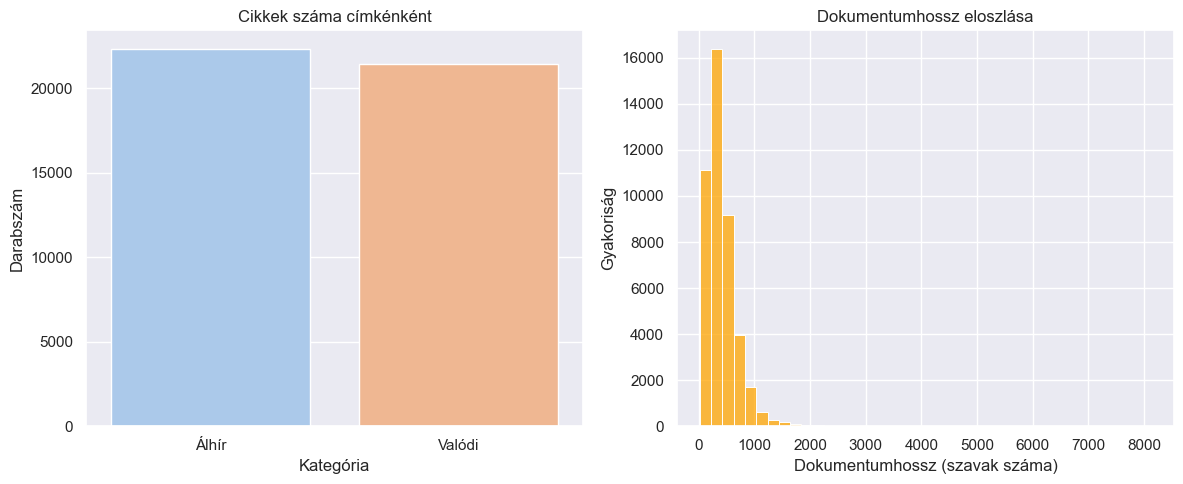

label
0    22313
1    21416
Name: count, dtype: int64

In [7]:
# Alap statisztikák és vizualizáció
label_counts = df["label"].value_counts().sort_index()
label_names = {0: "Álhír", 1: "Valódi"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=[label_names[i] for i in label_counts.index], y=label_counts.values, ax=axes[0], palette="pastel")
axes[0].set_title("Cikkek száma címkénként")
axes[0].set_ylabel("Darabszám")
axes[0].set_xlabel("Kategória")

sns.histplot(df["text_len"], bins=40, ax=axes[1], color="orange")
axes[1].set_title("Dokumentumhossz eloszlása")
axes[1].set_xlabel("Dokumentumhossz (szavak száma)")
axes[1].set_ylabel("Gyakoriság")

plt.tight_layout()
plt.show()

label_counts


### 2.4 Rövid értelmezés
A címkék megoszlásából látszik, hogy mindkét kategóriából több tízezer cikk áll rendelkezésre, így kiegyensúlyozott és nagy mintán dolgozunk. A szószám-eloszlás alapján jellemzően hosszabb cikkek szerepelnek, ami bőven elegendő információt biztosít a modelleknek és teljesíti a beadandó dokumentumkövetelményét.

## 3. Szöveg előfeldolgozás
A szövegeket megtisztítjuk: kisbetűsítés, URL-ek/számok eltávolítása, stopword szűrés és lemmatizálás spaCy-vel. Ez lesz az alap a későbbi vektorizáláshoz és modellezéshez.

In [8]:
# Stopword lista és tisztító függvény
stop_words = set(stopwords.words("english"))

# Egyszerű előfeldolgozó: lower, URL/ szám eltávolítás, tokenizálás, lemmatizálás
def preprocess_text(text: str) -> str:
    text_lower = str(text).lower()
    text_no_url = re.sub("http\S+|www\S+", " ", text_lower)
    text_no_num = re.sub("\d+", " ", text_no_url)
    text_clean = re.sub("\s+", " ", text_no_num).strip()

    doc = nlp(text_clean)
    tokens = []
    for token in doc:
        if token.is_punct or token.is_space or token.is_stop:
            continue
        lemma = token.lemma_.lower().strip()
        if len(lemma) < 3 or lemma in stop_words:
            continue
        tokens.append(lemma)
    return " ".join(tokens)


In [9]:
# Tisztított szöveg oszlop létrehozása
df["clean_text"] = df["text"].apply(preprocess_text)

# Minta a tisztított szövegekből
df[["title", "text", "clean_text"]].head()


,title,text,clean_text
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",donald trump wish americans happy new year leave instead shout enemy hater dishonest fake news medium reality star job country rapidly grow strong smart want wish friend supporter enemy hater dish...
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",house intelligence committee chairman devin nunes bad day assumption like christopher steele dossier prompt russia investigation lash department justice fbi order protect trump happen dossier star...
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",friday reveal milwaukee sheriff david clarke consider homeland security secretary donald trump administration email scandal own.in january brief run plane clarke fellow passenger dan black later d...
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Bar...",christmas day donald trump announce work follow day golf fourth day row reality star blast president barack obama play golf trump track outpace number golf game predecessor played.update tracker t...
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned T...,pope francis annual christmas day message rebuke donald trump mention pope deliver message day member united nations condemn trump recognize jerusalem capital israel pontiff pray monday peaceful c...


C:\Users\Bobo\AppData\Local\Temp\ipykernel_21604\1355800296.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), orient="h", palette="viridis")


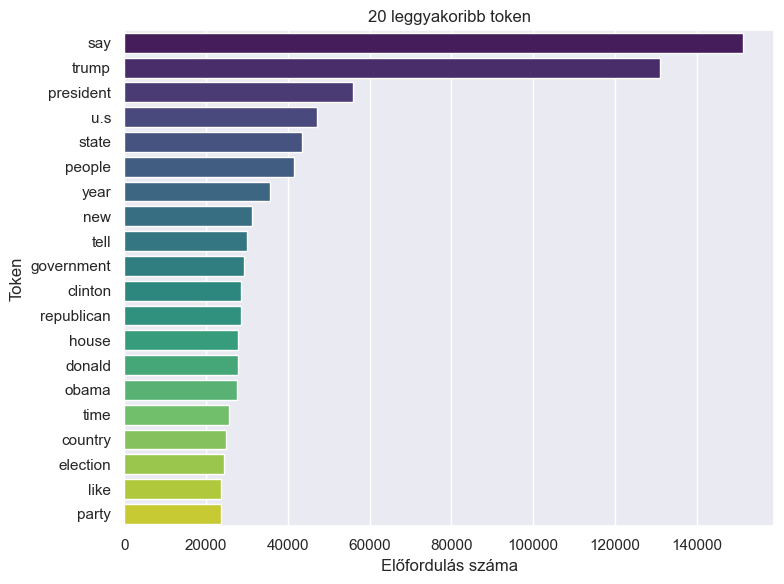

In [10]:
# Gyakori szavak vizsgálata
word_counts = Counter()
for doc in df["clean_text"]:
    word_counts.update(doc.split())

common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(8, 6))
sns.barplot(x=list(counts), y=list(words), orient="h", palette="viridis")
plt.title("20 leggyakoribb token")
plt.xlabel("Előfordulás száma")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


## 4. Tanító- és teszthalmaz
A tisztított szövegeket és a címkéket szétválasztjuk tanító- és teszthalmazra stratifikált módon, hogy a címkearányok megmaradjanak.

In [11]:
# Train–test split
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(f"Tanító minták: {len(X_train)}")
print(f"Teszt minták: {len(X_test)}")


Tanító minták: 34983
Teszt minták: 8746


## 5. Osztályozás TF-IDF alapú reprezentációval
A TF-IDF vektorizálás után két klasszikus modellt próbálunk: logisztikus regressziót és lineáris SVM-et (LinearSVC), majd összehasonlítjuk a teljesítményüket.

In [12]:
# TF-IDF vektorizálás
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF mátrix mérete (train): {X_train_tfidf.shape}")
print(f"TF-IDF mátrix mérete (test): {X_test_tfidf.shape}")


TF-IDF mátrix mérete (train): (34983, 20000)
TF-IDF mátrix mérete (test): (8746, 20000)


In [13]:
# Logisztikus regresszió modell
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
log_reg_pred = log_reg.predict(X_test_tfidf)

print("Logisztikus regresszió eredmények")
print(classification_report(y_test, log_reg_pred, target_names=["Álhír", "Valódi"]))
print("Konfúziós mátrix:")
print(confusion_matrix(y_test, log_reg_pred))


Logisztikus regresszió eredmények
              precision    recall  f1-score   support

       Álhír       0.99      0.99      0.99      4463
      Valódi       0.99      0.99      0.99      4283

    accuracy                           0.99      8746
   macro avg       0.99      0.99      0.99      8746
weighted avg       0.99      0.99      0.99      8746

Konfúziós mátrix:
[[4413   50]
 [  28 4255]]


In [14]:
# LinearSVC modell
svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)
svc_pred = svc.predict(X_test_tfidf)

print("LinearSVC eredmények")
print(classification_report(y_test, svc_pred, target_names=["Álhír", "Valódi"]))

log_reg_f1 = f1_score(y_test, log_reg_pred, average="weighted")
svc_f1 = f1_score(y_test, svc_pred, average="weighted")
print(f"Összehasonlítás – súlyozott F1: LogReg = {log_reg_f1:.3f}, LinearSVC = {svc_f1:.3f}")


c:\Users\Bobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC eredmények
              precision    recall  f1-score   support

       Álhír       1.00      1.00      1.00      4463
      Valódi       1.00      1.00      1.00      4283

    accuracy                           1.00      8746
   macro avg       1.00      1.00      1.00      8746
weighted avg       1.00      1.00      1.00      8746

Összehasonlítás – súlyozott F1: LogReg = 0.991, LinearSVC = 0.998


## 6. Témamodellezés (LDA)
A dokumentumok egy részén LDA-val témákat keresünk, hogy lássuk, milyen fő témakörök rajzolódnak ki a cikkekben.

In [15]:
# Tokenizált lista LDA-hoz
sampled_docs = df["clean_text"].sample(5000, random_state=RANDOM_STATE)
texts_for_lda = [doc.split() for doc in sampled_docs]

print(f"Felhasznált dokumentumok száma az LDA-hoz: {len(texts_for_lda)}")


Felhasznált dokumentumok száma az LDA-hoz: 5000


In [16]:
# Dictionary és corpus
dictionary = Dictionary(texts_for_lda)
corpus = [dictionary.doc2bow(text) for text in texts_for_lda]

print(f"Egyedi tokenek száma: {len(dictionary)}")


Egyedi tokenek száma: 50696


In [17]:
# LDA modell tanítása
lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=8,
    random_state=RANDOM_STATE,
    passes=5,
)

for idx, topic in lda.print_topics(num_topics=8, num_words=10):
    print(f"Téma {idx}: {topic}")


Téma 0: 0.015*"say" + 0.014*"clinton" + 0.012*"state" + 0.008*"court" + 0.007*"election" + 0.007*"vote" + 0.006*"obama" + 0.005*"democratic" + 0.005*"u.s" + 0.005*"email"
Téma 1: 0.018*"say" + 0.009*"u.s" + 0.008*"trump" + 0.007*"house" + 0.007*"state" + 0.007*"tax" + 0.007*"year" + 0.006*"republican" + 0.006*"bill" + 0.005*"company"
Téma 2: 0.027*"say" + 0.010*"military" + 0.008*"government" + 0.008*"state" + 0.007*"syria" + 0.007*"force" + 0.007*"refugee" + 0.006*"united" + 0.006*"u.s" + 0.006*"reuters"
Téma 3: 0.031*"trump" + 0.018*"say" + 0.012*"president" + 0.010*"russia" + 0.010*"u.s" + 0.008*"russian" + 0.007*"house" + 0.006*"donald" + 0.006*"official" + 0.005*"white"
Téma 4: 0.009*"police" + 0.007*"say" + 0.006*"people" + 0.005*"year" + 0.004*"report" + 0.004*"officer" + 0.004*"gun" + 0.004*"man" + 0.004*"city" + 0.004*"group"
Téma 5: 0.025*"say" + 0.012*"china" + 0.011*"u.s" + 0.011*"north" + 0.009*"korea" + 0.008*"united" + 0.007*"states" + 0.006*"trade" + 0.005*"nuclear" + 0

### 6.4 Rövid értelmezés
Az LDA témákban jellemzően politikai, világpolitikai és vélemény jellegű kulcsszavak jelennek meg (pl. választások, elnökök, külpolitika). Ez illeszkedik a hírportálos forráshoz, ahol a cikkek nagy része aktuális közéleti és nemzetközi eseményekhez kapcsolódik. A témák eloszlása jelzi, hogy az álhírek és valódi hírek hasonló tematikus mezőben mozognak, ami megnehezíti az osztályozást és indokolja a szövegalapú modellek használatát.

## 7. Szóvektorok és vizualizáció
A témamodellezés mellett szóvektorokat is tanítunk, hogy megnézzük a szavak közötti hasonlóságokat és azok térbeli elrendezését t-SNE segítségével.

In [18]:
# Word2Vec tanítása
w2v_model = Word2Vec(
    sentences=texts_for_lda,
    vector_size=100,
    window=5,
    min_count=10,
    workers=4,
    seed=RANDOM_STATE,
)

print(f"Szókészlet mérete: {len(w2v_model.wv.index_to_key)}")


Szókészlet mérete: 8530


In [19]:
# Hasonló szavak vizsgálata
vizsgalt_szavak = ["trump", "clinton", "election", "president", "government"]
for word in vizsgalt_szavak:
    if word in w2v_model.wv:
        print(f"Legközelebbi szavak: {word}")
        for hasonlo, score in w2v_model.wv.most_similar(word, topn=5):
            print(f"  {hasonlo} (koszinusz hasonlóság: {score:.3f})")
    else:
        print(f"A(z) '{word}' nincs a szótárban a beállított min_count miatt.")

Legközelebbi szavak: trump
  elect (koszinusz hasonlóság: 0.610)
  @realdonaldtrump (koszinusz hasonlóság: 0.584)
  trump.the (koszinusz hasonlóság: 0.577)
  @donaldjtrumpjr (koszinusz hasonlóság: 0.546)
  mac (koszinusz hasonlóság: 0.531)
Legközelebbi szavak: clinton
  crooked (koszinusz hasonlóság: 0.773)
  email (koszinusz hasonlóság: 0.586)
  crook (koszinusz hasonlóság: 0.574)
  trail (koszinusz hasonlóság: 0.567)
  dnc (koszinusz hasonlóság: 0.561)
Legközelebbi szavak: election
  nomination (koszinusz hasonlóság: 0.649)
  contest (koszinusz hasonlóság: 0.647)
  electoral (koszinusz hasonlóság: 0.639)
  bid (koszinusz hasonlóság: 0.622)
  nominating (koszinusz hasonlóság: 0.618)
Legközelebbi szavak: president
  barack (koszinusz hasonlóság: 0.644)
  biden (koszinusz hasonlóság: 0.598)
  michelle (koszinusz hasonlóság: 0.583)
  democratically (koszinusz hasonlóság: 0.574)
  pence (koszinusz hasonlóság: 0.570)
Legközelebbi szavak: government
  authority (koszinusz hasonlóság: 0.687)

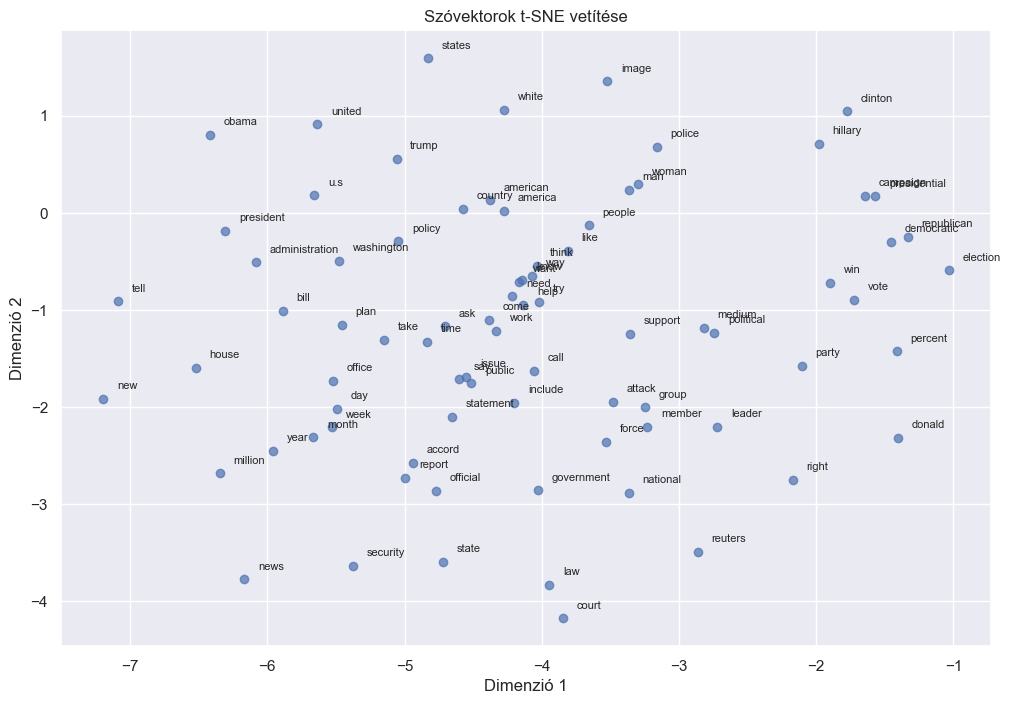

In [20]:
# t-SNE vizualizáció néhány gyakori szóra
max_szavak = 80
kivalasztott_szavak = w2v_model.wv.index_to_key[:max_szavak]
vektorok = np.array([w2v_model.wv[w] for w in kivalasztott_szavak])

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter=1000)
vektorok_2d = tsne.fit_transform(vektorok)

plt.figure(figsize=(12, 8))
plt.scatter(vektorok_2d[:, 0], vektorok_2d[:, 1], alpha=0.7)
for i, word in enumerate(kivalasztott_szavak):
    plt.text(vektorok_2d[i, 0] + 0.1, vektorok_2d[i, 1] + 0.1, word, fontsize=8)
plt.title("Szóvektorok t-SNE vetítése")
plt.xlabel("Dimenzió 1")
plt.ylabel("Dimenzió 2")
plt.show()


## 8. Egyszerű gráf alapú reprezentáció
A gyakori szavak együtt-előfordulásából kis gráfot építünk, és kirajzoljuk a kapcsolati hálót.

In [21]:
# Co-occurrence gráf építése
top_words_for_graph = [w for w, _ in word_counts.most_common(40)]
G = nx.Graph()
G.add_nodes_from(top_words_for_graph)

for doc in df["clean_text"].sample(3000, random_state=RANDOM_STATE):
    tokens = [t for t in doc.split() if t in top_words_for_graph]
    unique_tokens = set(tokens)
    for w1, w2 in combinations(unique_tokens, 2):
        if G.has_edge(w1, w2):
            G[w1][w2]["weight"] += 1
        else:
            G.add_edge(w1, w2, weight=1)

print(f"Csúcsok száma: {G.number_of_nodes()}, Élek száma: {G.number_of_edges()}")


Csúcsok száma: 40, Élek száma: 780


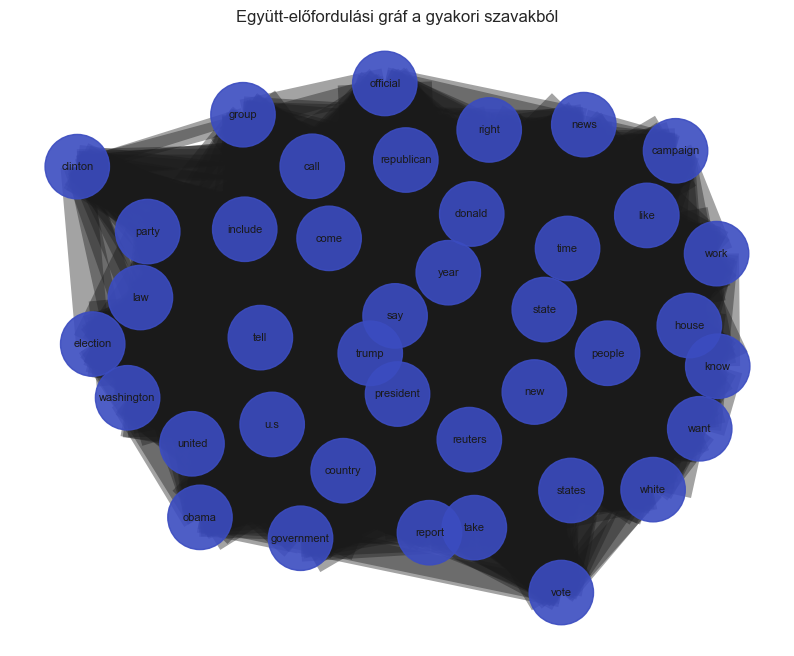

In [22]:
# Gráf vizualizálása
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=RANDOM_STATE, k=0.5)

degrees = np.array([G.degree(n) for n in G.nodes()])
nx.draw_networkx_nodes(G, pos, node_size=200 + degrees * 50, node_color=degrees, cmap="coolwarm", alpha=0.9)
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in edge_weights], alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Együtt-előfordulási gráf a gyakori szavakból")
plt.axis("off")
plt.show()


## 9. Összefoglalás
Ebben a notebookban beolvastuk és megtisztítottuk a hírcikkeket, TF-IDF alapú logisztikus regresszió és LinearSVC modelleket tanítottunk, valamint LDA témamodellezést futtattunk. A szóvektorok és a t-SNE vizualizáció megmutatta a szavak közti hasonlóságokat, míg a co-occurrence gráf a gyakori kapcsolatokra világított rá. További bővítési irány lehet mélyebb tisztítás (pl. név-szűrés), erősebb modellek (pl. BERT), illetve összehasonlítás többféle vektorizálással vagy időbeli elemzéssel.